<a href="https://colab.research.google.com/github/LastChanceKatze/image-caption-gen/blob/main/img_caption_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Duboko učenje - Generisanje opisa slike**
**Studenti**: 
 - Natalija Stamenković, 1258
 - Milica Todorović, 1256

**Tema**: Generisanje deskriptcije/opisa na osnovu date slike (*eng. image caption generator*). Korišćeni skup podataka može se naći na linku: https://www.kaggle.com/ming666/flicker8k-dataset.

## ***Imports***

In [ ]:
from os import listdir
import string
from pickle import dump, load
import tensorflow.keras.applications.vgg16 as vgg16
import tensorflow.keras.applications.inception_v3 as inception_v3
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras_preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint, CSVLogger
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from keras.applications.vgg16 import preprocess_input  
from keras.applications.inception_v3 import preprocess_input
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### *Relevantne putanje*

In [ ]:
drive_folder = "/content/drive/MyDrive/DL"
vgg_img_features_path = f"{drive_folder}/training_files/img_features.pkl"
inc_img_features_path = f"{drive_folder}/training_files/img_features_inc_v3.pkl"
img_train_path = f"{drive_folder}/Dataset/Flickr8k_text/Flickr_8k.trainImages.txt"
img_test_path = f"{drive_folder}/Dataset/Flickr8k_text/Flickr_8k.devImages.txt"
captions_filename = f"{drive_folder}/training_files/captions.txt"
glove_path = f"{drive_folder}/glove/glove.txt"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Preprocesiranje***

Preprocesiranje datih podataka svodi se na preprocesiranje/čišćenje datih opisa slika, kao i na ekstrakciju fičer vektora iz slika korišćenjem određenog CNN modela. Funkcije iz ove sekcije preprocesirane podatke čuvaju u okviru fajlova te ih je dovoljno pokrenuti samo jednom. 

#### *Preprocesiranje opisa slika*

Preprocesiranje opisa slika podrazumeva čišćenje naziva slika kojima je opis pridružen, kao i uklanjanje interpunkcijskih, alfanumeričkih znakova i reči koje sadrže samo jedno slovo. Nakon procesiranja, očišćeni opisi čuvaju se u okviru novog fajla u obliku liste: *image_id caption*.

In [ ]:
def load_captions(filename):
    """
    Load captions from file and create a per image caption dictionary
    :param filename:
    :return:
    """
    # read from the captions file
    file = open(filename, "r")
    text = file.read()
    file.close()

    mapping = dict()

    # process each line
    # line is in form: image_name.jpg#no caption
    for line in text.split("\n"):
        token = line.split("\t")

        if len(line) < 2:
            continue

        # first token: image id
        # rest: image caption
        img_id, img_capt = token[0], token[1:]
        # extract image id: before the .jpg part
        img_id = img_id.split('.')[0]
        # convert caption list back to string
        img_capt = ' '.join(img_capt)

        # add all the captions od the same image to image_id key
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_capt)

    return mapping


def clean_captions(captions):
    """
    Remove punctuation, hanging s and a, and tokens with numbers
    from the captions
    :param captions:
    :return:
    """
    # Prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for _, caption_list in captions.items():
        for i in range(len(caption_list)):
            caption = caption_list[i]
            # Tokenize i.e. split on white spaces
            caption = caption.split()
            # Convert to lowercase
            caption = [word.lower() for word in caption]
            # Remove punctuation from each token
            caption = [w.translate(table) for w in caption]
            # Remove hanging 's' and 'a'
            caption = [word for word in caption if len(word)>1]
            # Remove tokens with numbers in them
            caption = [word for word in caption if word.isalpha()]
            # Store as string
            caption_list[i] = ' '.join(caption)


def save_captions(captions_dict, to_file):
    """
    Save the captions_dict to a file,
    file: image_id caption_list per line
    :param captions_dict:
    :param to_file:
    :return:
    """
    # convert captions dictionary to string of lines
    lines = list()
    for key, caption_list in captions_dict.items():
        for caption in caption_list:
            lines.append(key + ' ' + caption)
    data = '\n'.join(lines)

    # save captions string to a file
    file = open(to_file, 'w')
    file.write(data)
    file.close()


def preprocess_captions(capt_filename=f"{drive_folder}/Dataset/Flickr8k_text/Flickr8k.token.txt",
                        clean_capt_to_file=f"{drive_folder}/training_files/captions.txt"):
    captions_dict = load_captions(capt_filename)
    clean_captions(captions_dict)
    save_captions(captions_dict, clean_capt_to_file)

In [ ]:
preprocess_captions()

#### *Ekstrakcija fičer vektora iz slika*

Dalje je potrebno izvršiti ekstrakciju fičer vektora iz datih slika korišćenjem izabranih CNN modela. Ova implementacija podrazumeva fičer vektore 2 različita CNN modela: *VGG-16* i *Inception V3*, najznačajniji parametri kreiranja ovih modela dati su u okviru dictionary-ja koji se generiše narednom funkcijom.

In [ ]:
def create_cnn_model_dict():
  cnn_model_dict = dict()

  cnn_model_dict['vgg16'] = {
      'model': vgg16.VGG16(),
      'target_size': (224, 224),
      'preprocess_input': vgg16.preprocess_input
  }

  cnn_model_dict['inception_v3'] = {
      'model': inception_v3.InceptionV3(),
      'target_size': (299, 299),
      'preprocess_input': inception_v3.preprocess_input
  }
  return cnn_model_dict

Sledeća funkcija omogućava ekstrakciju korišćenjem datog modela, pri čemu je, pre propuštanja slike potrebno iz modela izbaciti poslednji sloj. Povratna vrednost date metode je dictionary (image_id, feature_vector). Dati fičeri su nakon ekstrakcije sačuvani u fajl, kako se ovaj korak ne bi morao ponavljati pri svakom treniranju enkoder-dekoder modela.

In [ ]:
def extract_features(images_dir, model_type, cnn_model_dict):
    """
    Extract feature vectors from images in a folder using a specific model_type
    """
    model = cnn_model_dict[model_type]['model']
    target_size = cnn_model_dict[model_type]['target_size']
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    model.summary()

    features_dict = dict()

    img_count = 0

    for name in listdir(images_dir):
      filename = f"{images_dir}/{name}"
      image = load_img(filename, target_size=target_size)
      image = img_to_array(image)
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      image = cnn_model_dict[model_type]['preprocess_input'](image)
      features = model.predict(image, verbose=0)
      image_id = name.split('.')[0]
      features_dict[image_id] = features
      
      img_count += 1

      if img_count % 200 == 0:
        print("No. images", img_count)
        print()

      print(".", end="")

    return features_dict

def save_img_features(img_features, to_file):
  dump(img_features, open(to_file, "wb"))

def preprocess_img_features(images_dir=f"{drive_folder}/Dataset/Flickr8k_Dataset/Flicker8k_Dataset",
                            to_file=f"{drive_folder}/training_files/img_features_vgg16.pkl",
                            model_type="vgg16"):
  cnn_model_dict = create_cnn_model_dict()
  features = extract_features(images_dir, model_type, cnn_model_dict)
  print("No. features", len(features))
  save_img_features(features, to_file)

In [ ]:
preprocess_img_features()

In [ ]:
preprocess_img_features(to_file=f"{drive_folder}/training_files/img_features_inc_v3.pkl",
                        model_type="inception_v3")

## ***Učitavanje preprocesiranih podataka***

S obzirom da su, pri prvom pokretanju, preprocesirani podaci sačuvani u odgovarajućim fajlovima, kreiranje i treniranje enkoder-dekoder modela zahteva učitavanje ovih podataka, što se postiže funkcijama datim u ovoj sekciji.

In [ ]:
def load_img_ids(filename):
    """
    Load image ids from a file
    """
    file = open(filename, "r")
    text = file.read()
    file.close()

    img_ids = list()
    for line in text.split("\n"):

        if len(line) < 1:
            continue

        img_id = line.split('.')[0]
        img_ids.append(img_id)

    return img_ids

In [ ]:
def load_img_features(img_features, train_ids, test_ids):
    """
    Load train and test features from a file
    :param img_features:
    :param train_ids:
    :param test_ids:
    :return:
    """
    features = load(open(img_features, "rb"))

    train_features = {train_id: features[train_id] for train_id in train_ids}
    test_features = {test_id: features[test_id] for test_id in test_ids}

    return train_features, test_features

Prilikom učitavanja pročišćenih opisa slika na početku svakog opisa dodaje se reč "startseq", dok se na kraj dodaje "endseq". Ove ključne reči biće značajne prilikom treniranja modela.

In [ ]:
def load_clean_captions(filename, dataset):
    """
    load captions from file and create entry for each imgId from dataset
    """
    file = open(filename, 'r')
    text = file.read()
    file.close()

    captions = dict()

    for line in text.split('\n'):

        tokens = line.split()
        img_id, img_caption = tokens[0], tokens[1:]

        if img_id in dataset:
            if img_id not in captions:
                captions[img_id] = list()

            # add startseq at the begining and endseq at the end of each caption
            caption = 'startseq ' + ' '.join(img_caption) + ' endseq'
            captions[img_id].append(caption)

    return captions

Učitavanje i podela podataka na trening i test omogućena je sledećim pozivima (skup podataka sadrži posebne fajlove sa id-evima trening i test slika zasebno).

In [ ]:
img_train_ids = load_img_ids(img_train_path)
img_test_ids = load_img_ids(img_test_path)

train_captions = load_clean_captions(captions_filename, img_train_ids)
test_captions = load_clean_captions(captions_filename, img_test_ids)

vgg_train_features, vgg_test_features = load_img_features(vgg_img_features_path, img_train_ids, img_test_ids)
inc_train_features, inc_test_features = load_img_features(inc_img_features_path, img_train_ids, img_test_ids)


In [ ]:
print("Train images: ", len(vgg_train_features))
print("Train captions: ", len(train_captions))
print("Test images: ", len(vgg_test_features))
print("Test captions: ", len(test_captions))
print("VGG-16 feature vector:", len(vgg_train_features[img_train_ids[0]][0]))
print("Inception V3 feature vector:", len(inc_train_features[img_train_ids[0]][0]))

Train images:  6000
Train captions:  6000
Test images:  1000
Test captions:  1000
VGG-16 feature vector: 4096
Inception V3 feature vector: 2048


## ***Priprema podataka za treniranje modela***

Pre samog treniranja modela potrebno je dodatno pripremiti date podatke. Kako će se za treniranje koristiti varijacija seq2seq modela, opise slika je potrebno tokenizovati i generisati sekvence od datih opisa slika.

#### *Tokenizator*

Naredne funkcije omogućavaju kreiranje tokenizatora, korišćenjem standardne keras-ove implementacije, pri čemu se treniranje tokenizatora vrši nad opisima iz trening skupa podataka.

In [ ]:
def to_lines(captions):
    """
    Extract values from captions dictionary
    """
    all_captions = list()
    for key in captions.keys():
        [all_captions.append(d) for d in captions[key]]
    return all_captions


def create_tokenizer(captions):
    lines = to_lines(captions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


def calc_max_length(captions):
    lines = to_lines(captions)
    return max(len(line.split()) for line in lines)

In [ ]:
tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)
max_length = calc_max_length(train_captions)
print("Max caption length: ", max_length)

Vocabulary size:  7579
Max caption length:  34


Kako bi se izbeglo ponovno treniranje, istrenirani tokenizator čuva se u okviru fajla.

In [ ]:
#save tokenizer 
dump(tokenizer, open(f'{drive_folder}/tokenizer.pkl', 'wb'))

#### *Kreiranje sekvenci i generatora podataka*

Kao što je prethodno napomenuto opisi slika mogu se smatrati sekvencom reči, te je od svakog opisa, za svaku reč u opisu potrebno izdvojiti sekvencu reči koja prethodi datoj reči (ulazna sekvenca), pri čemu data reč postaje izlazna vrednost. Određivanje sekvenci na osnovu pojedinačnog opisa vrši se prethodno definisanim tokenizatorom. Takođe, nakon "podele" opisa, potrebno je izlaznu reč enkodirati u kategoričku vrednost.

In [ ]:
def create_sequences(image, caption_list, tokenizer, max_length, vocab_size):
    """
    Generate sequences from a caption, containing just the first word, first two words etc.
    For word i in sequence, separate the caption into input=caption[:i] and next_word=caption[i];
    encode each word as a categorical value.
    :param image:
    :param caption_list:
    :param tokenizer:
    :param max_length:
    :param vocab_size:
    :return:
    """
    in_img_list, in_word_list, out_word_list = list(), list(), list()
    for capt in caption_list:
        # tokenize each caption
        seq = tokenizer.texts_to_sequences([capt])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode word to a categorical value
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            in_img_list.append(image)
            in_word_list.append(in_seq)
            out_word_list.append(out_seq)
    return in_img_list, in_word_list, out_word_list

Finalno, za pripremu podataka, potrebno je definisati *custom* generator podataka koji će omogućiti da se prethodno generisane sekvence reči "daju" odgovarajućem modelu u batch-evima odgovarajuće veličine. Takođe, generator podataka uvodi određenu nasumičnost prilikom kreiranja batch-eva, u cilju smanjenja pristrasnosti prilikom treniranja modela.

In [ ]:
def data_generator(images, captions, tokenizer, max_length, batch_size, random_seed, vocab_size):
    """
    Extract images, input word sequences and output word in batches. To be used while fitting the model.
    :param images:
    :param captions:
    :param tokenizer:
    :param max_length:
    :param batch_size:
    :param random_seed:
    :param vocab_size:
    :return:
    """
    random.seed(random_seed)

    img_ids = list(captions.keys())

    count = 0
    while True:
        if count >= len(img_ids):
            count = 0

        in_img_batch, in_seq_batch, out_word_batch = list(), list(), list()

        # get current batch indexes
        for i in range(count, min(len(img_ids), count+batch_size)):
            # current image_id
            img_id = img_ids[i]
            # current image
            img = images[img_id][0]
            # current image caption list
            captions_list = captions[img_id]
            # shuffle the captions
            random.shuffle(captions_list)
            # get word sequences and output word
            in_img, in_seq, out_word = create_sequences(img, captions_list,
                                                        tokenizer, max_length,
                                                        vocab_size)

            # append to batch list
            for j in range(len(in_img)):
                in_img_batch.append(in_img[j])
                in_seq_batch.append(in_seq[j])
                out_word_batch.append(out_word[j])

        count = count + batch_size
        yield [np.array(in_img_batch), np.array(in_seq_batch)], np.array(out_word_batch)

## ***Glove embedding***

U funkciji glove_embedding_indices izvršeno je mapiranje u dictionary glove embeding vektora. Zatim su izdvojene reči sa vektorima koje se javljaju u našem trening skupu.

In [ ]:
def glove_embedding_indices(glove_filepath):
    """
    Mapira world embedding fajl u dictionary, za svaku rec u fajlu
     mapira njene relacije
    :param word_index:
    :param vocab_size:
    :return:
    """
    embeddings_index = {}

    glove = open(glove_filepath, 'r', encoding='utf-8').read()
    for line in glove.split("\n"):
        values = line.split(" ")
        word = values[0]
        indices = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = indices

    return embeddings_index

def get_vocab_embedding_weights(embeddings_index, word_index, vocab_size, emd_dim=200):
    """
    Kreira embedding matricu za reci koje
     se javljaju u vocab_index
    :param embeddings_index:
    :param word_index:
    :param vocab_size: 
    :return: 
    """
    #emb_dim = 200
    emb_matrix = np.zeros((vocab_size, emb_dim))
    for word, i in word_index.items():
        emb_vec = embeddings_index.get(word)
        if emb_vec is not None:
            emb_matrix[i] = emb_vec

    return emb_matrix

In [ ]:
 emb_dim = 200

 def get_embedding_weights():
    embedding_matrix = glove_embedding_indices(glove_path)
    embedding_matrix_weights = get_vocab_embedding_weights(embedding_matrix, tokenizer.word_index, vocab_size, emb_dim)
    return embedding_matrix_weights

embedding_weights = get_embedding_weights()

## ***Definicije modela***

U ovoj sekciji date su metode koje omogućavaju kreiranje arhitekture enkoder-dekoder mreže. Ova implementacija podrazumeva dve slične arhitektura, pri čemu glavna razlika leži u Embedding sloju: jedna arhitektura koristi prethodno opisani GloVe, dok druga ne koristi. Obe arhitekture podrazumevaju kategoričku krosentropiju kao funkciju gubitka i Adam opitimizator.

#### *Bazični model*

Sledeća funkcija omogućava definisanje modela bez korišćenja GloVe u Embedding sloju. Model na ulazu očekuje dictionary sa parametrima, kako bi se omogućilo definisanje mreža sa različitim CNN arhitekturama, kao i drugačijim procentom *dropout*-a.

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length, params):	
  image_input = Input(shape=(params['input_dim'],))
  image_model_1 = Dropout(params['dropout_value'])(image_input)
  image_model = Dense(params['dense_units'], activation='relu')(image_model_1)

  caption_input = Input(shape=(max_length,))
	# mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs. E.g. it is an efficiency.
  
  caption_model_1 = Embedding(vocab_size, params['embedding_size'], mask_zero = True)(caption_input)

  caption_model_2 = Dropout(params['dropout_value'])(caption_model_1)
  caption_model = LSTM(params['lstm_units'])(caption_model_2)

	# Merging the models and creating a softmax classifier
  final_model_1 = concatenate([image_model, caption_model])
  final_model_2 = Dense(params['dense_units'], activation='relu')(final_model_1)
  final_model = Dense(vocab_size, activation='softmax')(final_model_2)

  model = Model(inputs=[image_input, caption_input], outputs=final_model)
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  return model

#### *Model sa GloVe embedingom*

Sledeća funkcija omogućava definisanje modela korišćenjem Glove embedding vektora. Ulazni parametri su definisani kao i kod prethodnog modela. U ovom modelu embedding sloju se pridodaje Glove težinska matrica. 

In [ ]:
# define the captioning model
def define_glove_model(vocab_size, max_length, params):	
  image_input = Input(shape=(params['input_dim'],))
  image_model_1 = Dropout(params['dropout_value'])(image_input)
  image_model = Dense(params['dense_units'], activation='relu')(image_model_1)

  caption_input = Input(shape=(max_length,))
	# mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs. E.g. it is an efficiency.
  
  caption_model_1 = Embedding(vocab_size, emb_dim, mask_zero = True)(caption_input)

  caption_model_2 = Dropout(params['dropout_value'])(caption_model_1)
  caption_model = LSTM(params['lstm_units'])(caption_model_2)

	# Merging the models and creating a softmax classifier
  final_model_1 = concatenate([image_model, caption_model])
  final_model_2 = Dense(params['dense_units'], activation='relu')(final_model_1)
  final_model = Dense(vocab_size, activation='softmax')(final_model_2)

  model = Model(inputs=[image_input, caption_input], outputs=final_model)

  model.layers[2].set_weights([embedding_weights])
  model.layers[2].trainable = False

  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # model.summary()

  return model

## ***Treniranje modela***

Funkcija korišćena pri treniranju modela na ulazu očekuje dictionary sa parametrima, kako bi se omogućilo fleksibilno treniranje. Svako treniranje, u odgovarajućem folderu, datom svojom putanjom, čuva najbolji model (uzimajući u obzir gubitak na validacionim podacima), kao i log treniranja.

In [ ]:
def train_model(params):
  train_steps = len(params['train_captions']) // params['batch_size'] 
  if len(params['train_captions']) % params['batch_size']  != 0:
    train_steps = train_steps + 1

  test_steps = len(params['test_captions']) // params['batch_size']
  if len(params['test_captions']) % params['batch_size'] != 0:
    test_steps = test_steps + 1

  checkpoint = ModelCheckpoint(params['filepath'], monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  logger = CSVLogger(params['logger'])

  train_generator = data_generator(params['train_features'], params['train_captions'], params['tokenizer'], params['max_length'], params['batch_size'], 10, params['vocab_size'])
  test_generator = data_generator(params['test_features'], params['test_captions'], params['tokenizer'], params['max_length'], params['batch_size'], 10, params['vocab_size'])

  model = params['model']
  history = model.fit(train_generator, epochs = params['epochs'], steps_per_epoch = train_steps,
            validation_data=test_generator, validation_steps = test_steps,
            callbacks=[checkpoint, logger], verbose=1)
  
  return model

U nastavku ove sekcije dati su eksperimenti pri treniranju modela za generisanje opisa. Radi veće preglednosti notebook-a trening log je izostavljen iz ove sekcije, a detaljna diskusija o valjanosti modela biće data prilikom evaluacije modela u narednoj sekciji.

#### *Bazični model: VGG-16*

Treniranje modela korišćenjem bazičnog modela sa konvolucionom mrežom VGG-16.

##### Dense units (256) - Dropout (0.5)

In [ ]:
vgg_5_256_model_params = {
    'input_dim': 4096,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.5,
    'embedding_size': 256
    }
vgg_5_256_model = define_model(vocab_size, max_length, vgg_5_256_model_params)
vgg_5_256_train_params = {
    'model':vgg_5_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/vgg_0.5_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/vgg_0.5_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': vgg_train_features,
    'test_features': vgg_test_features
    }
train_model(vgg_5_256_train_params)

##### Dense units (256) - Dropout (0.3)

In [ ]:
vgg_3_256_model_params = {
    'input_dim': 4096,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.3,
    'embedding_size': 256
    }
vgg_3_256_model = define_model(vocab_size, max_length, vgg_3_256_model_params)
vgg_3_256_train_params = {
    'model':vgg_3_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/vgg_0.3_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/vgg_0.3_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': vgg_train_features,
    'test_features': vgg_test_features
    }
train_model(vgg_3_256_train_params)

##### Dense units (128) - Dropout (0.3)

In [ ]:
vgg_3_128_model_params = {
    'input_dim': 4096,
    'dense_units': 128,
    'lstm_units': 128,
    'dropout_value':0.3,
    'embedding_size': 128
    }
vgg_3_128_model = define_model(vocab_size, max_length, vgg_3_128_model_params)
vgg_3_128_train_params = {
    'model':vgg_3_128_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/vgg_0.3_128/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/vgg_0.3_128/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': vgg_train_features,
    'test_features': vgg_test_features
    }
train_model(vgg_3_128_train_params)

#### *Bazični model: Inception V3*

Treniranje modela korišćenjem bazičnog modela sa konvolucionom mrežom Inception V3.

##### Dense units (256) - Dropout (0.5)

In [ ]:
inc_5_256_model_params = {
    'input_dim': 2048,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.5,
    'embedding_size': 256
     }
inc_5_256_model = define_model(vocab_size, max_length, inc_5_256_model_params)
inc_5_256_train_params = {
    'model':inc_5_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/inc_v3_0.5_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/inc_v3_0.5_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': inc_train_features,
    'test_features': inc_test_features
    }
train_model(inc_5_256_train_params)

##### Dense units (256) - Dropout (0.3)

In [ ]:
inc_3_256_model_params = {
    'input_dim': 2048,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.3,
    'embedding_size': 256
     }
inc_3_256_model = define_model(vocab_size, max_length, inc_3_256_model_params)
inc_3_256_train_params = {
    'model':inc_3_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/inc_v3_0.3_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/inc_v3_0.3_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': inc_train_features,
    'test_features': inc_test_features
    }
train_model(inc_3_256_train_params)

##### Dense units (128) - Dropout (0.3)

In [ ]:
inc_3_128_model_params = {
    'input_dim': 2048,
    'dense_units': 128,
    'lstm_units': 128,
    'dropout_value':0.3,
    'embedding_size': 128
     }
inc_3_128_model = define_model(vocab_size, max_length, inc_3_128_model_params)
inc_3_128_train_params = {
    'model':inc_3_128_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/inc_v3_0.3_128/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/inc_v3_0.3_128/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': inc_train_features,
    'test_features': inc_test_features
    }
train_model(inc_3_128_train_params)

#### *Model sa GloVe embedingom: VGG-16*

Treniranje modela korišćenjem modela sa GloVe embedingom i konvolucionom mrežom VGG-16.

In [ ]:
glove_models_path  = drive_folder + "/glove_model"

glove_models_vgg_path = glove_models_path + "/Vgg16"

vgg_dropout_03_path = glove_models_vgg_path + "/Dropout-0.3"

vgg_dropout_05_path = glove_models_vgg_path + "/Dropout-0.5"


##### Dense units (128) - Dropout (0.3)

In [ ]:
vgg_dropout_03_dense_128_path = vgg_dropout_03_path + "/dense-128"

In [ ]:
vgg_glove_3_128_model_params = {'dropout_value':0.3,
     'dense_units': 128,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_3_128_model = define_glove_model(vocab_size, max_length, vgg_glove_3_128_model_params)

vgg_glove_3_128_train_params = {'model':vgg_glove_3_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': vgg_dropout_03_dense_128_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger':  vgg_dropout_03_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_3_128_train_params)

##### Dense units (256) - Dropout (0.3)

In [ ]:
vgg_dropout_03_dense_256_path = vgg_dropout_03_path + "/dense-256"

In [ ]:
vgg_glove_3_256_model_params = {'dropout_value':0.3,
     'dense_units': 256,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_3_256_model = define_glove_model(vocab_size, max_length, vgg_glove_3_256_model_params)

vgg_glove_3_256_train_params = {'model':vgg_glove_3_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': vgg_dropout_03_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger': vgg_dropout_03_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_3_256_train_params)

##### Dense units (128) - Dropout (0.5)

In [ ]:
vgg_dropout_05_dense_128_path = vgg_dropout_05_path + "/dense-128"

In [ ]:
vgg_glove_5_128_model_params = {'dropout_value':0.5,
     'dense_units': 128,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_5_128_model = define_glove_model(vocab_size, max_length, vgg_glove_5_128_model_params)

vgg_glove_5_128_train_params = {'model':vgg_glove_5_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': vgg_dropout_05_dense_128_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger':  vgg_dropout_05_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_5_128_train_params)

##### Dense units (256) - Dropout (0.5)

In [ ]:
vgg_dropout_05_dense_256_path = vgg_dropout_05_path + "/dense-256"

In [ ]:
vgg_glove_5_256_model_params = {'dropout_value':0.5,
     'dense_units': 256,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_5_256_model = define_glove_model(vocab_size, max_length, vgg_glove_5_256_model_params)

vgg_glove_5_256_train_params = {'model':vgg_glove_5_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': vgg_dropout_05_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger':  vgg_dropout_05_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_5_256_train_params)

#### *Model sa GloVe embedingom: Inception V3*

Treniranje modela korišćenjem modela sa GloVe embedingom i konvolucionom mrežom Inception V3.

In [ ]:
glove_models_inception_v3_path = glove_models_path + "/InceptionV3"

inc_dropout_03_path = glove_models_inception_v3_path + "/Dropout-0.3"

inc_dropout_05_path = glove_models_inception_v3_path + "/Dropout-0.5"

##### Dense units (128) - Dropout (0.3)

In [ ]:
inc_dropout_03_dense_128_path = inc_dropout_03_path + "/dense-128"

In [ ]:
inc_glove_3_128_model_params = {'dropout_value':0.3,
     'dense_units': 128,
     'input_dim': 2048,
     'lstm_units': 256
     }

inc_glove_3_128_model = define_glove_model(vocab_size, max_length, inc_glove_3_128_model_params)

inc_glove_3_128_train_params = {'model': inc_glove_3_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_03_dense_128_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger':  inc_dropout_03_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(inc_glove_3_128_train_params)

##### Dense units (256) - Dropout (0.3)

In [ ]:
inc_dropout_03_dense_256_path = inc_dropout_03_path + "/dense-256"

In [ ]:
inc_glove_3_256_model_params = {'dropout_value':0.3,
     'dense_units': 256,
     'input_dim': 2048,
     'lstm_units': 256
     }

inc_glove_3_256_model = define_glove_model(vocab_size, max_length, inc_glove_3_256_model_params)

inc_glove_3_256_train_params = {'model':inc_glove_3_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_03_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger': inc_dropout_03_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(vgg_glove_3_256_train_params)

##### Dense units (128) - Dropout (0.5)

In [ ]:
inc_dropout_05_dense_128_path = inc_dropout_05_path + "/dense-128"

In [ ]:
inc_glove_5_128_model_params = {'dropout_value':0.5,
     'dense_units': 128,
     'input_dim': 2048,
     'lstm_units': 256
     }

inc_glove_5_128_model = define_glove_model(vocab_size, max_length, inc_glove_5_128_model_params)

inc_glove_5_128_train_params = {'model':inc_glove_5_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_05_dense_128_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger':  inc_dropout_05_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(inc_glove_5_128_train_params)

##### Dense units (256) - Dropout (0.5)

In [ ]:
inc_dropout_05_dense_256_path = inc_dropout_05_path + "/dense-256"

In [ ]:
inc_glove_5_256_model_params = {'dropout_value':0.5,
     'dense_units': 256,
     'input_dim': 2048,
     'lstm_units': 256
     }

inc_glove_5_256_model = define_glove_model(vocab_size, max_length, inc_glove_5_256_model_params)

inc_glove_5_256_train_params = {'model':inc_glove_5_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_05_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger':  inc_dropout_05_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(inc_glove_5_256_train_params)

## ***Evaluacija modela***

Evaluacija modela vrši se na osnovu BLEU skora, čija je implementacija dostupna u okviru NLTK biblioteke.

In [ ]:
def index_to_word(word_index, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == word_index:
            return word
    return None


def generate_caption(model, tokenizer, image, max_length):
    in_caption = "startseq"

    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_caption])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        pred = model.predict([image, seq], verbose=0)
        pred = np.argmax(pred)
        word = index_to_word(pred, tokenizer)

        if word is None:
            break

        in_caption += ' ' + word

        if word == 'endseq':
            break

    return in_caption


def evaluate_model(model, images, captions, tokenizer, max_lenght):
    test, predicted = list(), list()

    img_count = 0
    for key, caption_list in captions.items():
        pred = generate_caption(model, tokenizer, images[key], max_lenght)

        predicted.append(pred.split())
        test.append([capt.split() for capt in caption_list])

        img_count += 1

        if img_count % 200 == 0:
          print("No. images", img_count)
          print()

        print(".", end="")

    print()    
    print("BLEU-1 ", corpus_bleu(test, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2 ", corpus_bleu(test, predicted, weights=(.5, .5, 0, 0)))
    print("BLEU-3 ", corpus_bleu(test, predicted, weights=(.3, .3, .3, 0)))
    print("BLEU-4 ", corpus_bleu(test, predicted))

Procesu odabira najpovoljnijem modelu može pomoći i pregled istorije treniranja, odnosno kretanja funkcije gubitka nad trening i test skupovima podataka.

In [ ]:
def plot_history(log_filepath):
    df = pd.read_csv(log_filepath)
    plt.plot(df['loss'])
    plt.plot(df['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss through epochs')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

S obzirom da su istrenirani modeli prehodno sačuvani, evaluacija podrazumeva učitavanje odgovarajućeg modela, prikaza istorije treniranja i BLEU skorova.

In [ ]:
def load_eval(model_path, model_log_path, test_features, test_captions, tokenizer, max_length):
  model = load_model(model_path)
  model.summary()
  print("Training history:")
  plot_history(model_log_path)
  print("Evaluate model:")
  evaluate_model(model, test_features, test_captions, tokenizer, max_length)
  return model

#### *Bazični model: VGG-16*

Evaluacija modela korišćenjem bazičnog modela sa konvolucionom mrežom VGG-16.

##### Dense units (256) - Dropout (0.3)

Model podrazumeva 256 neurona u *dense* sloju sa dropout-om od 0.3. Može se primetiti da je BLEU skor relativno zadovoljavajući ali i da model overfit-uje.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

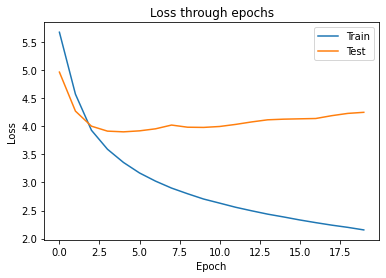

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
vgg_3_256_model = load_eval(f"{drive_folder}/model/vgg_0.3_256/ep005-loss3.354-val_loss3.898.h5",
                            f"{drive_folder}/model/vgg_0.3_256/training.log",
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (256) - Dropout (0.5)

Pokušaj smanjenja overfit-a uključuje povećanje dropout-a na 0.5, pri čemu se može primetiti da se BLEU skor za nijansu poboljšao, ali da problem "pretreniranja" ostaje.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

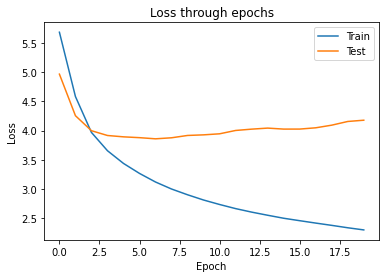

.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................................

In [ ]:
vgg_5_256_model = load_eval(f"{drive_folder}/model/vgg_0.5_256/ep007-loss3.118-val_loss3.859.h5",
                            f"{drive_folder}/model/vgg_0.5_256/training.log",
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (128) - Dropout (0.3)

Naredni model manjuje broj neurona u *dense* sloju, pri čemu se pokazuje da se skor znatno pogoršao te se dati model odbacuje.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 128)      970112      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

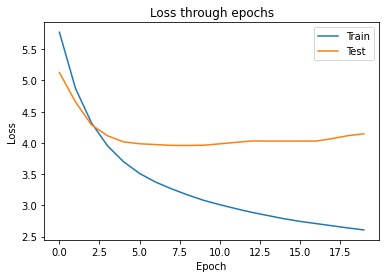

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
vgg_3_128_model = load_eval(f"{drive_folder}/model/vgg_0.3_128/ep009-loss3.167-val_loss3.959.h5",
                            f"{drive_folder}/model/vgg_0.3_128/training.log",
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

***Može se zaključiti da najbolji skor, korišćenjem VGG-16 konvolucione mreže, daje model sa 256 neurona u dense sloju i dropout-om 0.5.***

#### *Bazični model: Inception V3*

Evaluacija modela korišćenjem bazičnog modela sa konvolucionom mrežom Inception V3.

##### Dense units (256) - Dropout (0.3)

Pokazuje se da ovaj model daje relativno sličan skor model koji se do sada pokazao kao najbolji.

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 256)      1940224     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_7[0][0]                    
____________________________________________________________________________________________

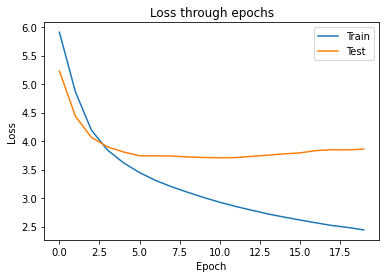

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
inc_3_256_model = load_eval(f"{drive_folder}/model/inc_v3_0.3_256/ep011-loss2.929-val_loss3.708.h5",
                            f"{drive_folder}/model/inc_v3_0.3_256/training.log",
                            inc_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (256) - Dropout (0.5)

Slično kao u prethodnom slučaju, nastoji se smanjenje overfit-a prvo povećanjem dropout-a. Međutim, u ovom slučaju, ispostavlja se da ovakva arhitektura daje gore rezultate, te se ovaj model odbacuje.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
______________________________________________________________________________________________

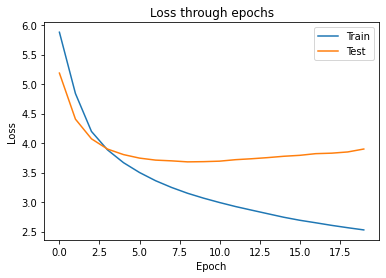

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
inc_5_256_model = load_eval(f"{drive_folder}/model/inc_v3_0.5_256/ep009-loss3.149-val_loss3.681.h5",
                            f"{drive_folder}/model/inc_v3_0.5_256/training.log",
                            inc_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (128) - Dropout (0.3)

Pokušaj redukovanja ovetfit-a smanjenjem broja neurona u dense sloju se pokazuje dobro, s obzirom da se dobija poboljšanje BLEU skora, kao i vidna redukcija razlike funkcije gubitka nad trening i test podacima.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 128)      970112      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

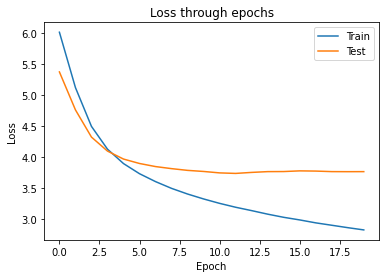

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
inc_3_128_model = load_eval(f"{drive_folder}/model/inc_v3_0.3_128/ep012-loss3.191-val_loss3.736.h5",
                            f"{drive_folder}/model/inc_v3_0.3_128/training.log",
                            inc_test_features, test_captions,
                            tokenizer, max_length)

***Može se zaključiti da najbolji skor, korišćenjem Inception V3 konvolucione mreže, daje model sa 128 neurona u dense sloju i dropout-om 0.3.***

#### *Model sa GloVe embedingom: VGG-16*

##### Dense units (256) - Dropout (0.3)

U poređenju sa prethodnim modelima ovakva struktura daje gore rezultate pa se samim tim odbacuje.

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 34, 200)      1515800     input_16[0][0]                   
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 4096)         0           input_15[0][0]                   
____________________________________________________________________________________________

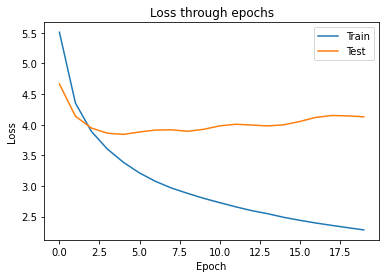

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = vgg_dropout_03_dense_256_path + "/ep005-loss3.386-val_loss3.843.h5"
training_log_path = vgg_dropout_03_dense_256_path + "/training.log"

vgg_glove_3_256_model = load_eval(model_path,
                            training_log_path,
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (256) - Dropout (0.5)

U poređenju sa prethodnom, povećan je dropout što daje značajno bolje rezultate.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      1515800     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

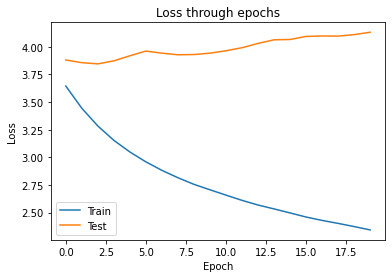

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = vgg_dropout_05_dense_256_path + "/ep003-loss3.283-val_loss3.846.h5"
training_log_path = vgg_dropout_05_dense_256_path + "/training.log"

vgg_glove_5_256_model = load_eval(model_path,
                            training_log_path,
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (128) - Dropout (0.3)

Takođe je isprobana arhitekuta sa 128 dense unitsa. Ona daje slične rezultate kao i prethodna arhitektura.

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 34, 200)      1515800     input_14[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 4096)         0           input_13[0][0]                   
____________________________________________________________________________________________

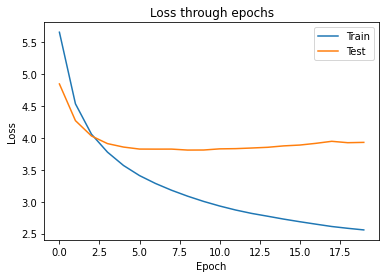

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = vgg_dropout_03_dense_128_path + "/ep009-loss3.087-val_loss3.809.h5"
training_log_path = vgg_dropout_03_dense_128_path + "/training.log"

vgg_glove_3_128_model = load_eval(model_path,
                            training_log_path,
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (128) - Dropout (0.5)

Zatim je povećan dropout na 0.5 što daje slične rezultate kao i arhitektura sa istim dropout-om i 256 dense unit-a

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 200)      1515800     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 4096)         0           input_7[0][0]                    
____________________________________________________________________________________________

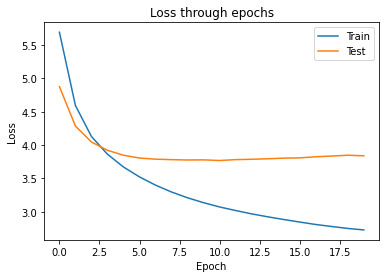

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = vgg_dropout_05_dense_128_path + "/ep011-loss3.071-val_loss3.768.h5"
training_log_path = vgg_dropout_05_dense_128_path + "/training.log"

vgg_glove_5_128_model = load_eval(model_path,
                            training_log_path,
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

#### *Model sa GloVe embedingom: Inception V3*

##### Dense units (256) - Dropout (0.3)

Ova arhitektura daje najbolje rezultate do sada kada su u pitanju modeli sa Glove embedingom

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 34, 200)      1515800     input_26[0][0]                   
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 2048)         0           input_25[0][0]                   
___________________________________________________________________________________________

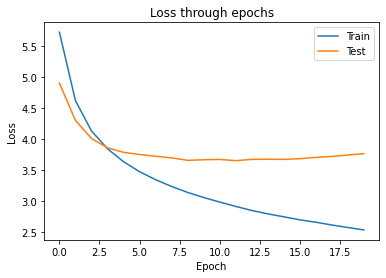

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = inc_dropout_03_dense_256_path + "/ep012-loss2.919-val_loss3.657.h5"
training_log_path = inc_dropout_03_dense_256_path + "/training.log"

inc_glove_3_256_model = load_eval(model_path,
                            training_log_path,
                            inc_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (256) - Dropout (0.5)

Povećavanjem dropout-a na 0.5 dolazi do pogoršavanja rezultata.

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 34, 200)      1515800     input_20[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 2048)         0           input_19[0][0]                   
____________________________________________________________________________________________

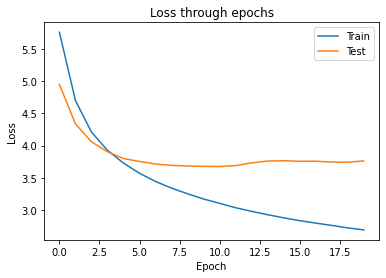

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = inc_dropout_05_dense_256_path + "/ep011-loss3.106-val_loss3.676.h5"
training_log_path = inc_dropout_05_dense_256_path + "/training.log"

inc_glove_5_256_model = load_eval(model_path,
                            training_log_path,
                            inc_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (128) - Dropout (0.3)

Sledeća arhitektura takođe ne daje bolje rezultate od ostalih.

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 34, 200)      1515800     input_24[0][0]                   
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 2048)         0           input_23[0][0]                   
___________________________________________________________________________________________

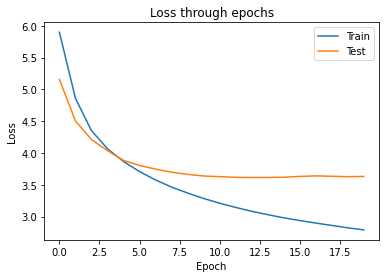

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = inc_dropout_03_dense_128_path + "/ep013-loss3.084-val_loss3.615.h5"
training_log_path = inc_dropout_03_dense_128_path + "/training.log"

inc_glove_3_128_model = load_eval(model_path,
                            training_log_path,
                            inc_test_features, test_captions,
                            tokenizer, max_length)

##### Dense units (128) - Dropout (0.5)

Povećavanjem dropout-a na 0.5 dolazi do poboljšanja rezultata, što daje slične rezultate kao i arhitektura sa 256 unitsa i 0.3 drop out-om.

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 34, 200)      1515800     input_22[0][0]                   
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 2048)         0           input_21[0][0]                   
____________________________________________________________________________________________

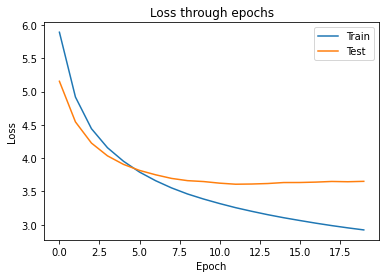

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [ ]:
model_path = inc_dropout_05_dense_128_path + "/ep012-loss3.256-val_loss3.608.h5"
training_log_path = inc_dropout_05_dense_128_path + "/training.log"

inc_glove_5_128_model = load_eval(model_path,
                            training_log_path,
                            inc_test_features, test_captions,
                            tokenizer, max_length)

## ***Generisanje opisa novih slika***

Finalno, prethodno dobijeni najbolji modeli biće iskorišćeni za generisanje opisa novih slika, ne bi li se utvrdila njihova uspešnost na subjektivnom nivou.

Kako data slika nije sadržana u okviru trening i test skupa podataka, potrebno je naknadno izvršiti ekstrakciju fičer vektora korišćenjem određene konvolucione mreže.

In [ ]:
# extract features from each photo in the directory
def extract_features(filename, model_type = "vgg16"):
   
  cnn_model_dict = create_cnn_model_dict()
  model = cnn_model_dict[model_type]["model"]
  model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

  image = load_img(filename, target_size = cnn_model_dict[model_type]["target_size"])
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = cnn_model_dict[model_type]["preprocess_input"](image)
  feature = model.predict(image, verbose=0)

  return feature

Učitavanje pretreniranog tokenizatora.

In [ ]:
tokenizer = load(open(drive_folder + '/tokenizer.pkl', 'rb'))

Funkcija za generisanje opisa slike na osnovu datog modela.

In [ ]:
# TODO: test when generating new caption
def generate_caption_file(filepath, model, model_type = "vgg16"):

  if not isfile(filepath):
    return "filepath is not a file"

  photo_feature = extract_features(filepath, model_type)
  caption = generate_caption(model, tokenizer, photo_feature, max_length)

  # remove startseq and endseq
  if caption is not None and len(caption) > 3:
    caption = caption[len('startseq') : len(caption) - len('endseq')]
    #caption = caption[1:len(caption)-1]

  return caption

# TODO: Remove, probably wont use
def generate_captions_dir(dirpath, model, model_type = "vgg16"):

  captions = dict()
  for file in listdir(dirpath):
    
    filepath = join(dirpath, file)

    if isfile(filepath):
       photo_feature = extract_features(filepath, model_type)
       caption = generate_caption(model_from_file, tokenizer, photo_feature, max_length)
       captions[filepath] = caption

  return captions

# TODO: same probably wont use
def print_captions(captions):
  for key, value in captions.items():
      print(key, ' : ', value)

#### *Bazični model: VGG-16*

In [ ]:
model_path = drive_folder + "/model/vgg_0.5_256/ep007-loss3.118-val_loss3.859.h5"
model_from_file = load_model(model_path)
max_length = 34

 three girls are sitting in front of the grass 


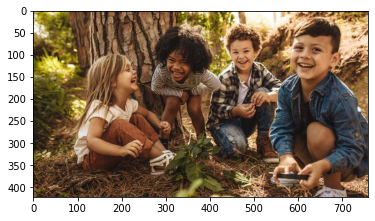

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo1.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo1.jpg"))
print(caption)

 white and white dog is running in the air 


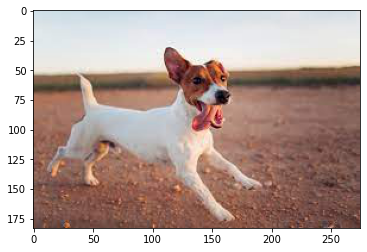

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo2.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo2.jpg"))
print(caption)

 two dogs are running through the grass 


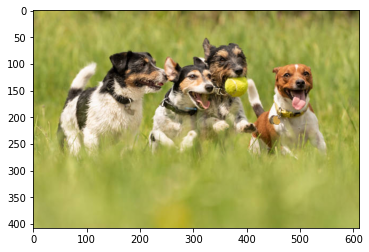

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo3.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo3.jpg"))
print(caption)

 child is jumping on the grass 


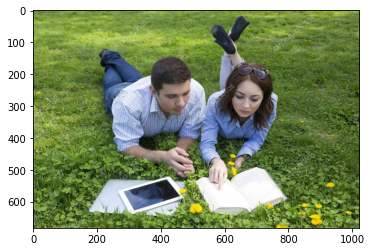

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo4.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo4.jpg"))
print(caption)

 two children are playing in field 


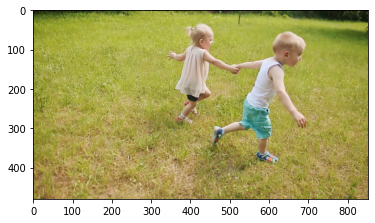

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo5.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo5.jpg"))
print(caption)

#### *Bazični model: Inception V3*

In [ ]:
model_path = drive_folder + "/model/inc_v3_0.3_128/ep012-loss3.191-val_loss3.736.h5"
model_from_file = load_model(model_path)

 two children are sitting on the camera 


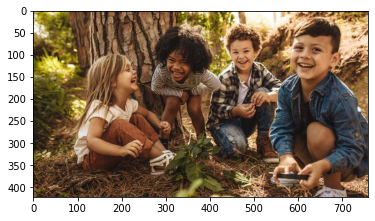

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo1.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo1.jpg"))
print(caption)

 two dogs are playing in the grass 


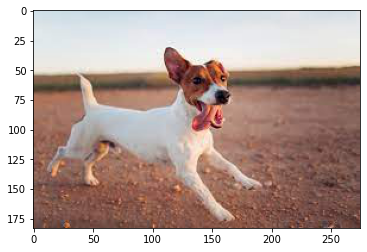

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo2.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo2.jpg"))
print(caption)

 two dogs are playing in the grass 


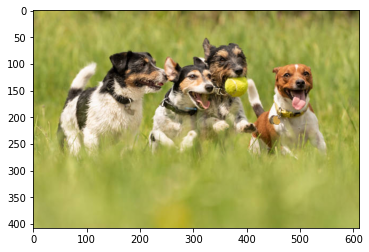

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo3.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo3.jpg"))
print(caption)

 little boy in red shirt is sitting on the grass with his arms 


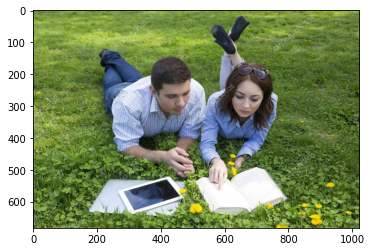

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo4.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo4.jpg"))
print(caption)

 young boy in pink shirt is running on the grass 


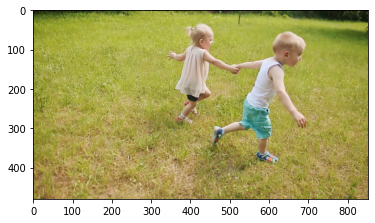

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo5.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo5.jpg"))
print(caption)

#### *Model sa GloVe embedingom: VGG-16*

In [ ]:
model_path = vgg_dropout_05_dense_256_path + "/ep003-loss3.283-val_loss3.846.h5"
model_from_file = load_model(model_path)

 two children sit on the street 


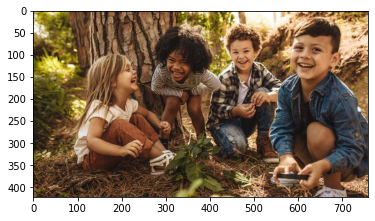

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo1.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo1.jpg"))
print(caption)

 white dog is running through the grass 


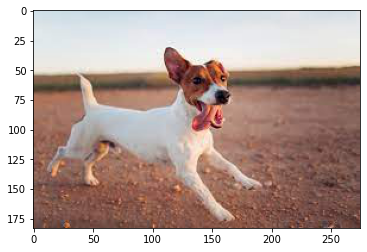

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo2.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo2.jpg"))
print(caption)

 two dogs run through the grass 


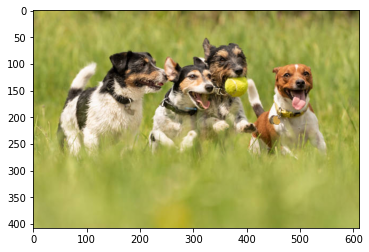

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo3.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo3.jpg"))
print(caption)

 little boy in yellow shirt is sitting on the grass 


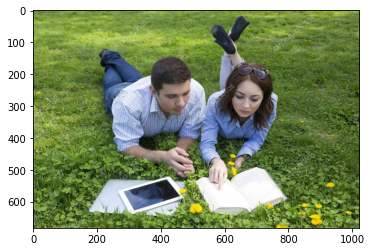

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo4.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo4.jpg"))
print(caption)

 two girls are playing in field 


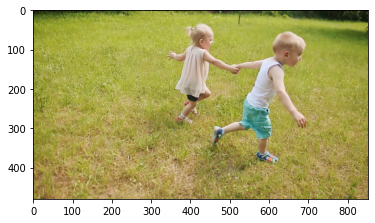

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo5.jpg", model_from_file, "vgg16")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo5.jpg"))
print(caption)

#### *Model sa GloVe embedingom: Inception V3*

In [ ]:
model_path = inc_dropout_03_dense_256_path + "/ep012-loss2.919-val_loss3.657.h5"
model_from_file = load_model(model_path)

 two girls are sitting on the grass 


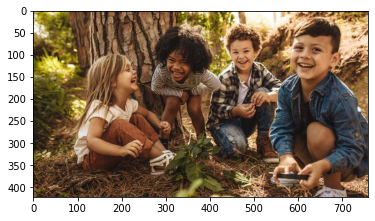

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo1.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo1.jpg"))
print(caption)

 two dogs are playing with ball in the snow 


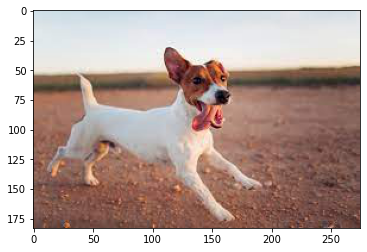

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo2.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo2.jpg"))
print(caption)

 two dogs are playing with ball in the grass 


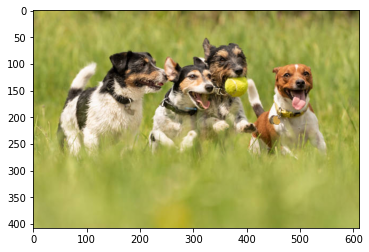

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo3.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo3.jpg"))
print(caption)

 two young boys are playing with large bag 


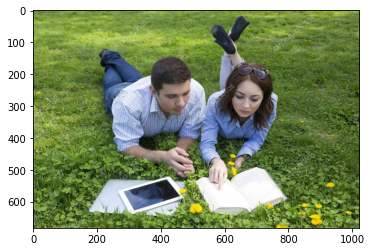

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo4.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo4.jpg"))
print(caption)

 young boy in pink shirt is running through the grass 


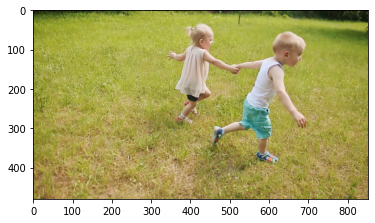

In [ ]:
caption = generate_caption_file(drive_folder+"/test_photos/photo5.jpg", model_from_file, "inception_v3")
plt.imshow(mpimg.imread(drive_folder+"/test_photos/photo5.jpg"))
print(caption)

## **Zakljucak**

Poređenjem *BLEU* skorova bazičnih modela možemo videti da najbolji skor daje model koji koristi *CNN* - *inception* model. Dok je na drugom mestu  model koji koristi *CNN* - *VGG*. Takođe poređenjem rezultata dobijenim generisanjem opisa pojedinaćnih slika možemo zaključiti da bazični *VGG* model generiše uverljivije opise slika. Što se tiče *GloVe*  modela, model koji koristi *CNN* - *inception* daje najbolji *BLEU* skor, bolji od *VGG* modela, ali poređenjem opisa fotografija možemo videti da i ovog puta *CNN* - *inception* daje gore opise. Što je kao i u prethodnom bazičnom modelu posledica manje preciznosti *inception* modela. Poređenjem rezultata *VGG* bazičnog modela i *VGG* *GloVe* modela može se zaključiti da bazični model daje za nijasnu bolje i preciznije opise, što je u skladu sa njegovim boljim *BLEU* skorom. Na kraju, došli smo do zaključka da bazični *VGG* model generiše najbolje opise fotografija.